# Regression analysis of Air Quality dataset
#### (predicting Benzene (C6H6(GT)) concentration)
##### Target - C6H6(GT)

### Data Set Information:
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.


### Attribute Information:
0 Date (DD/MM/YYYY)
1 Time (HH.MM.SS)
2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7 True hourly averaged NOx concentration in ppb (reference analyzer)
8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12 Temperature in Â°C
13 Relative Humidity (%)
14 AH Absolute Humidity









### Exploratory Data Analysis (EDA)

In [7]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
# Load dataset
import requests
import io

# I use the raw URL to download the raw CSV content from my github account
data_url = "https://raw.githubusercontent.com/kharkovsailing/EDA-with-Python/refs/heads/main/AirQualityUCI.csv"  # Updated URL

# Request the CSV data and decode it.
dataset = requests.get(data_url).content.decode('utf-8')

# Use StringIO to handle the text content like a file.
df = pd.read_csv(io.StringIO(dataset), sep=";", decimal=",")  # Added sep=";" and decimal=","

df.shape
# df.describe()


(9471, 17)

### Data preparation

In [9]:
# Replace missing values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

# Drop unnecessary columns (Date, Time)
df.drop(columns=['Date', 'Time'], inplace=True, errors='ignore')

# Check missing values
missing_values = df.isna().sum()


In [12]:
# Impute missing values with column median
df.fillna(df.median(), inplace=True)


In [13]:
# Univariate Analysis - Summary Statistics
summary_stats = df.describe()
print(summary_stats)

            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9471.000000  9471.000000  9471.000000  9471.000000    9471.000000   
mean      2.085820  1097.966424   156.640693     9.987668     937.625172   
std       1.315415   211.661265    66.657341     7.270307     260.065263   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.200000   943.000000   150.000000     4.600000     744.000000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.600000  1218.000000   150.000000    13.500000    1102.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9471.000000   9471.000000  9471.000000   9471.000000  9471.000000   
mean    234.514729    833.998839   112.332700   1456.605955  1019.870024   
std     194.006563    250.307741    43.684741    337.321954   388.476425   
min       2

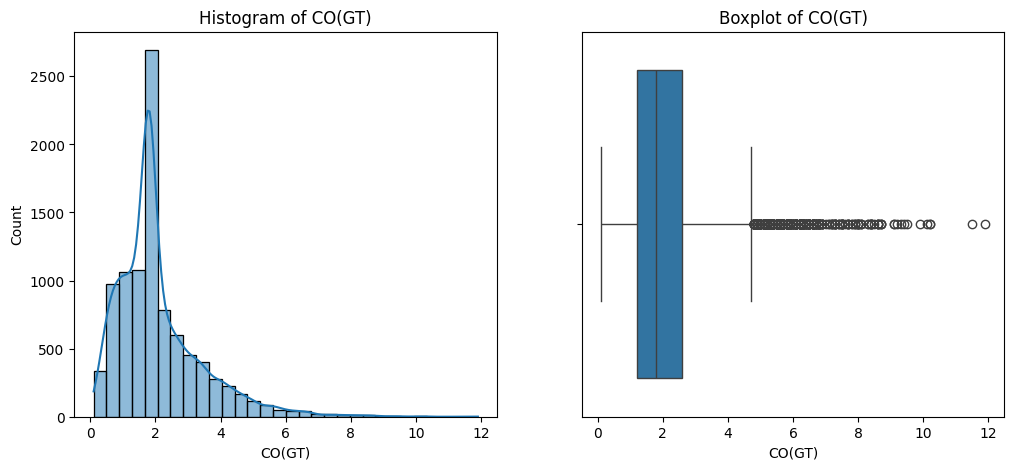

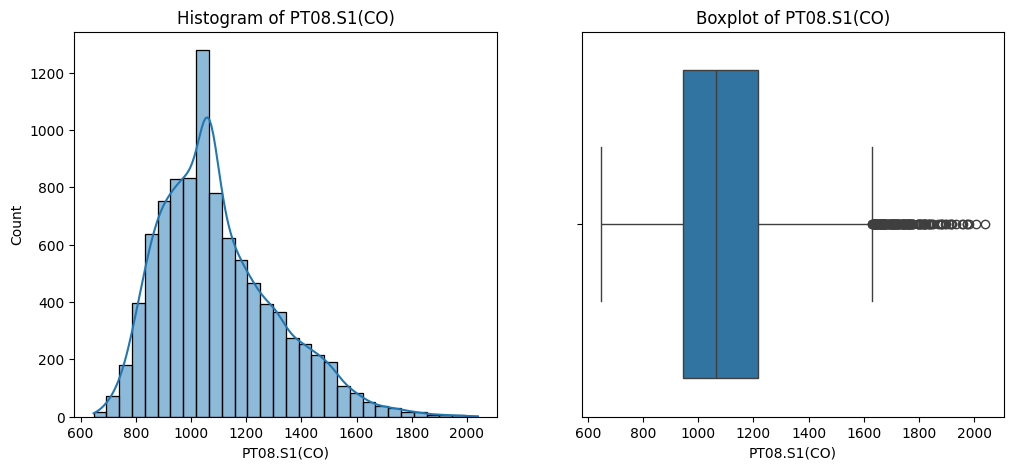

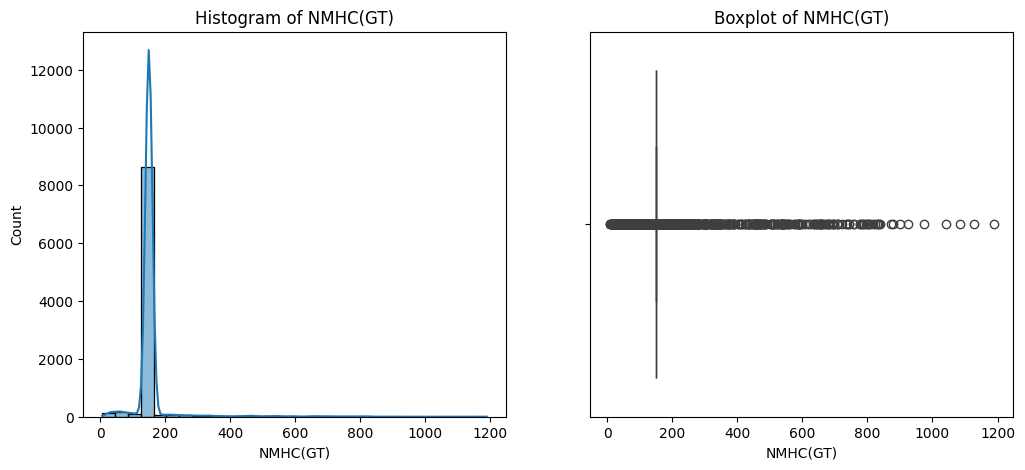

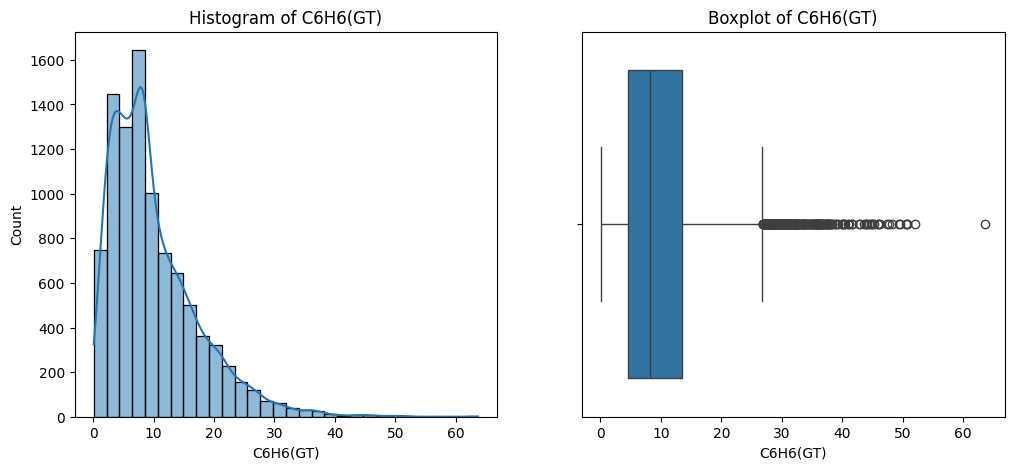

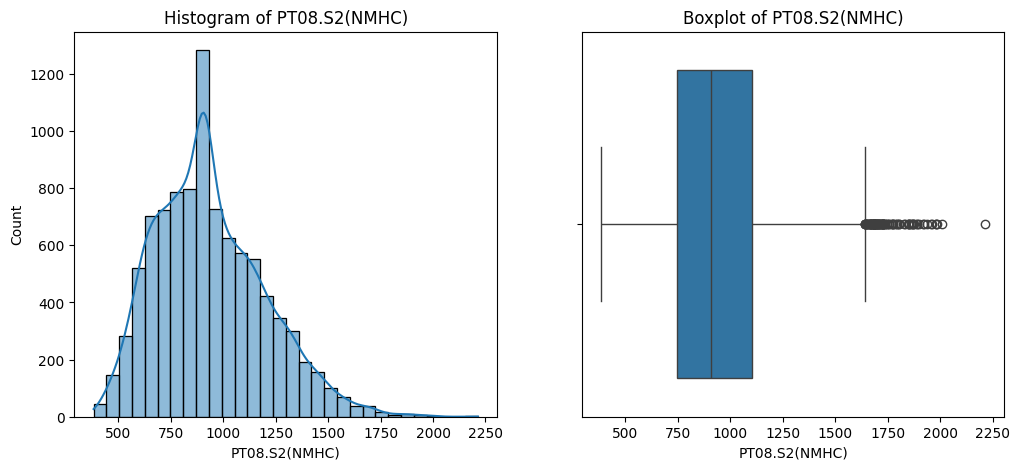

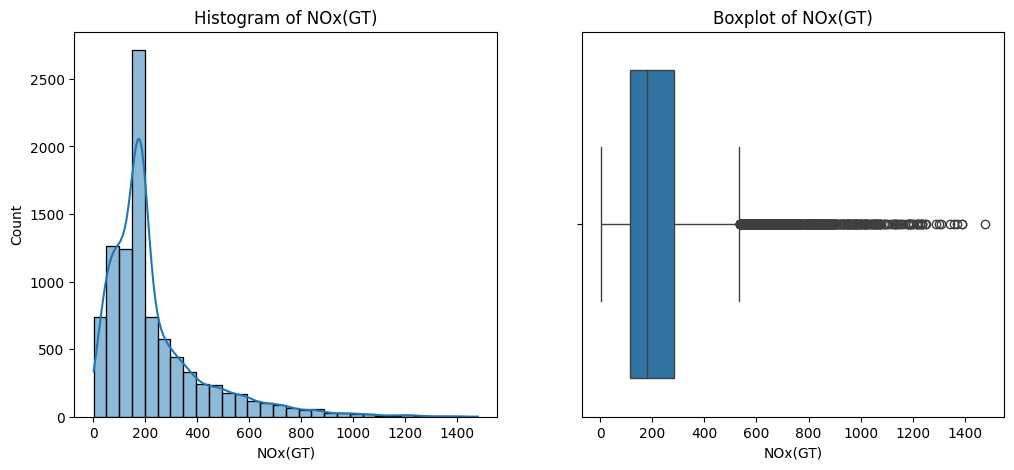

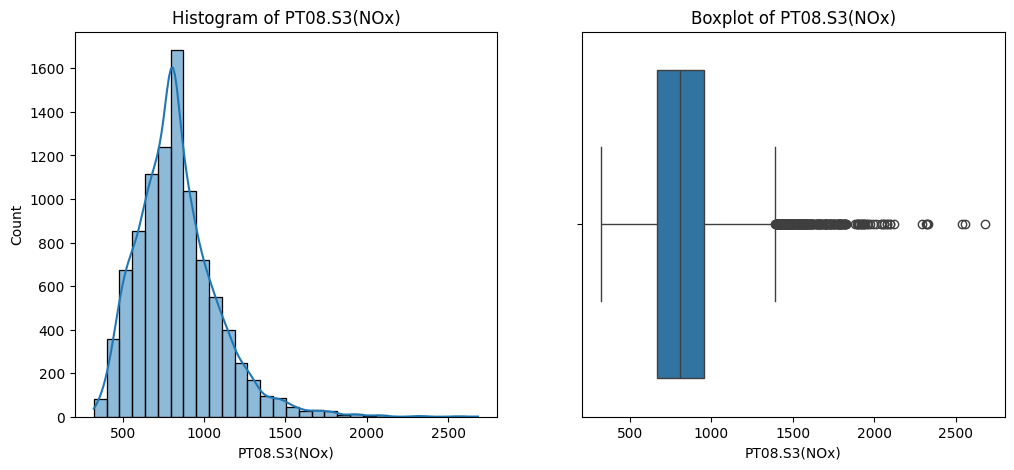

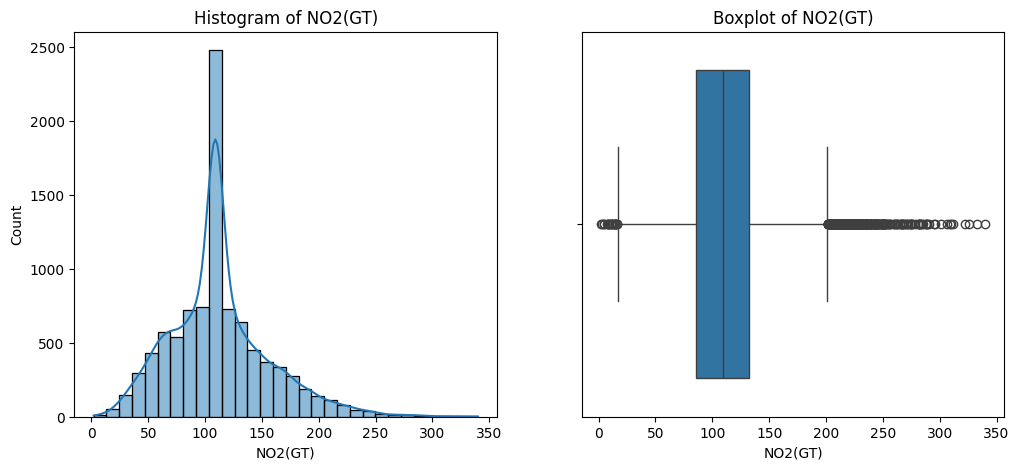

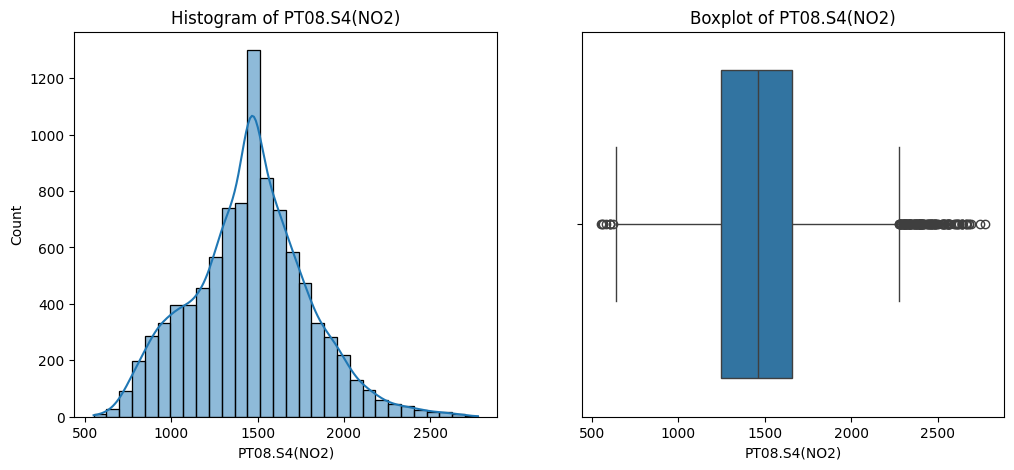

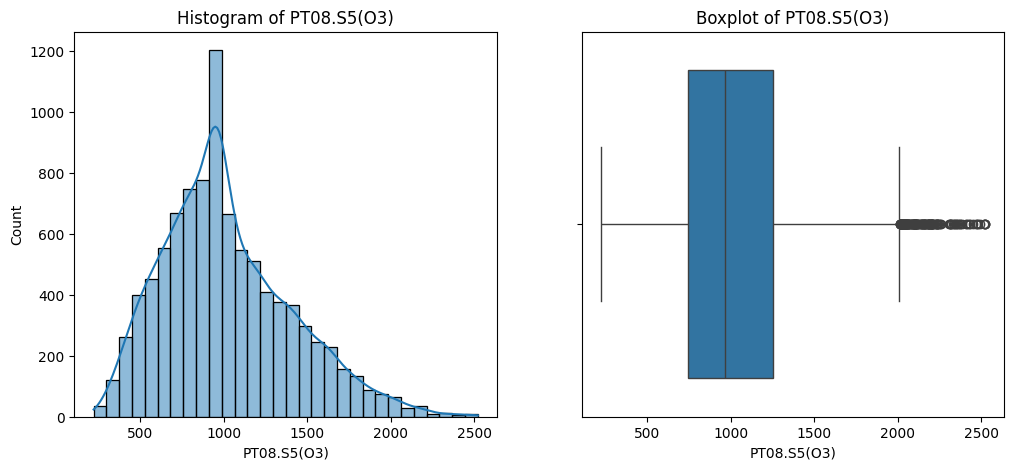

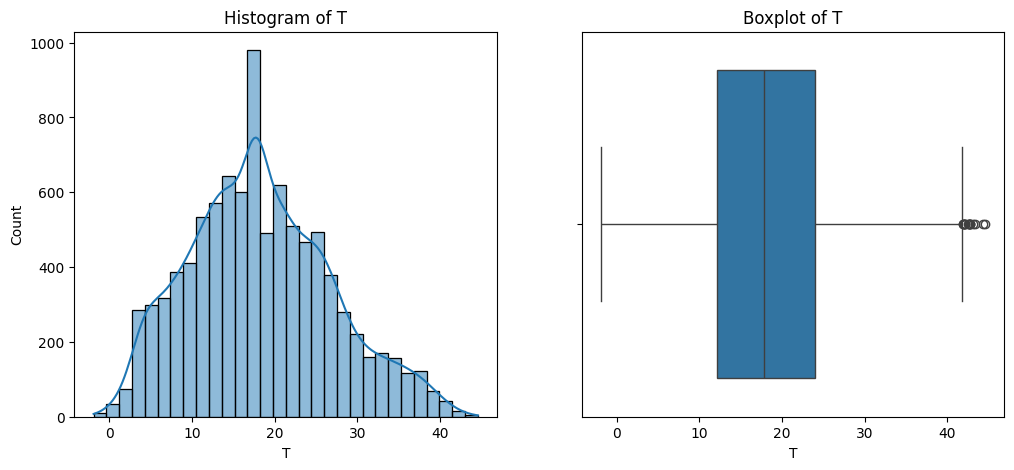

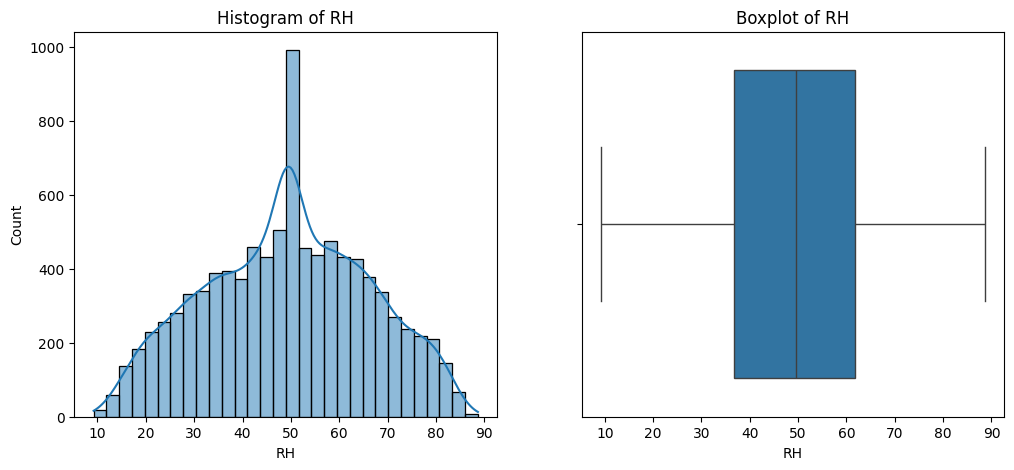

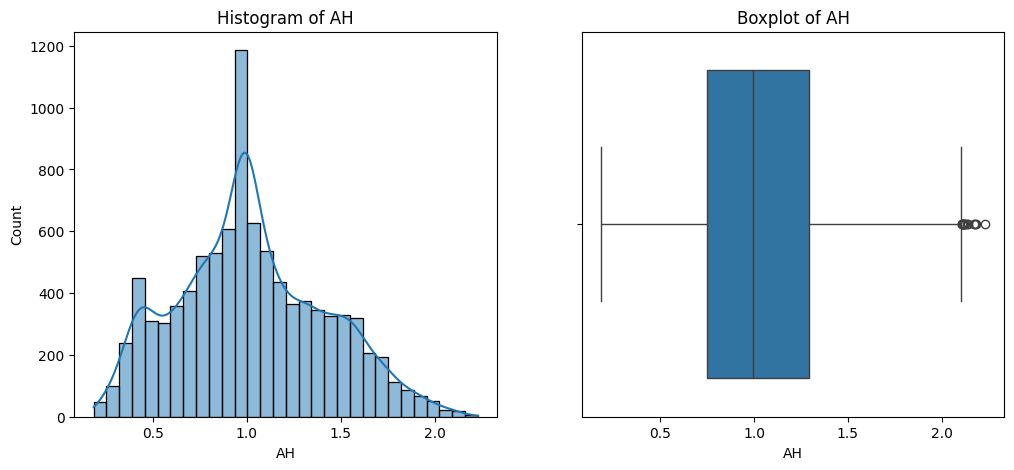

Skipping column 'Unnamed: 15' for boxplot and histogram due to non-numeric data type or column name 'Unnamed: 15' or 'Unnamed: 16'.
Skipping column 'Unnamed: 16' for boxplot and histogram due to non-numeric data type or column name 'Unnamed: 15' or 'Unnamed: 16'.


In [17]:
# Univariate Analysis - Histograms & Boxplots
for col in df.columns:
    # Check if column is numeric and not 'Unnamed: 15' or 'Unnamed: 16'
    if pd.api.types.is_numeric_dtype(df[col]) and col not in ['Unnamed: 15', 'Unnamed: 16']:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()
    else:
        print(f"Skipping column '{col}' for boxplot and histogram due to non-numeric data type or column name 'Unnamed: 15' or 'Unnamed: 16'.")

##### Feature Engineering (Basic transformations)

In [19]:
# Define features & target
target = 'C6H6(GT)'
X = df.drop(columns=[target])
y = df[target]

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Baseline Model (Linear Regression)

In [21]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Impute NaNs using SimpleImputer after scaling
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or strategy='median'
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Baseline Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [12 13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [12 13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [22]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

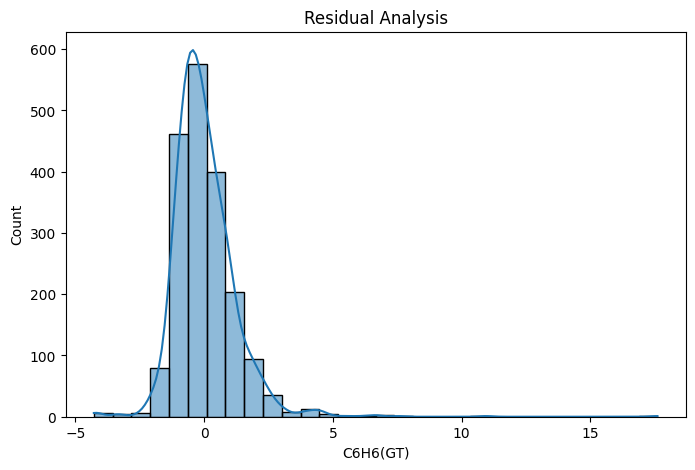

In [23]:
# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual Analysis')
plt.show()


In [24]:
print(f"Shape of X: {X.shape}")
print(f"Number of features in X: {len(X.columns)}")
print(f"Number of coefficients in model: {len(lr.coef_)}")
print("Feature names in X:", X.columns.tolist())


Shape of X: (9471, 14)
Number of features in X: 14
Number of coefficients in model: 12
Feature names in X: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']


In [25]:
# Drop unnamed columns if they exist
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [26]:
X = df.drop(columns=['C6H6(GT)'])  # Drop target column
y = df['C6H6(GT)']


In [27]:
print(f"Shape of X after fix: {X.shape}")
print(f"Number of coefficients: {len(lr.coef_)}")


Shape of X after fix: (9471, 12)
Number of coefficients: 12


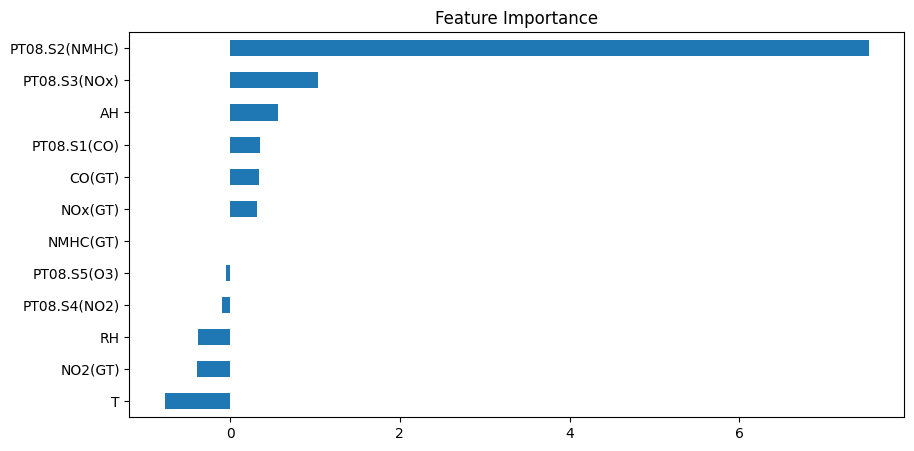

In [28]:
# Feature Importance
feature_importance = pd.Series(lr.coef_, index=X.columns).sort_values()
plt.figure(figsize=(10,5))
feature_importance.plot(kind='barh')
plt.title('Feature Importance')
plt.show()

In [29]:
# Print evaluation metrics
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R2 Score: {r2:.4f}')

MAE: 0.8417
RMSE: 1.2218
R2 Score: 0.9731
